# Vehicle Detection and Tracking
<div style="text-align: right"><font size="1">Alejandra Vargas - 02.01.18</font></div>


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

---

## Calibration and correction of distortion
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from os import path


def camera_cal(nx, ny, basepath):

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path.join(basepath, 'calibration*.jpg'))

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('input image',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)

    # Calibrate camera
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    destnation = path.join(basepath,'calibration_pickle.p')
    pickle.dump( dist_pickle, open( destnation, "wb" ) )
    print("New Calibration file: {}".format(destnation))

    return mtx, dist


def load_cal(calib_file):

    with open(calib_file, 'rb') as file:
        # print('load calibration data')
        data= pickle.load(file)
        mtx = data['mtx']       # calibration matrix
        dist = data['dist']     # distortion coefficients

    return mtx, dist


def cal_undistort(imagepath, calib_file, visulization_flag):

    mtx, dist = load_cal(calib_file)

    img = cv2.imread(imagepath)

    # Undistort images
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dstRGB = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    cv2.imwrite('camera_cal/calibration_undist*.jpg',dst)
    
    if visulization_flag:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(imgRGB)
        ax1.set_title('Original Image', fontsize=30)
        ax1.axis('off')
        ax2.imshow(dstRGB)
        ax2.set_title('Undistorted Image', fontsize=30)
        ax2.axis('off')
        plt.show()

    return dstRGB


if __name__ == "__main__":

    nx, ny = 9, 6  # number of grids along x and y axis in the chessboard pattern
    basepath = 'camera_cal/'  # path contain the calibration images

    # calibrate the camera and save the calibration data
    camera_cal(nx, ny, basepath)


New Calibration file: camera_cal/calibration_pickle.p


## Advanced Lane Lines - Project 4

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from copy import copy


class Lane():
    def __init__(self):
        # was the line detected in the last frame or not
        self.detected = False
        #x values for detected line pixels
        self.cur_fitx = None
        #y values for detected line pixels
        self.cur_fity = None
        # x values of the last N fits of the line
        self.prev_fitx = []
        #polynomial coefficients for the most recent fit
        self.current_poly = [np.array([False])]
        #best polynomial coefficients for the last iteration
        self.prev_poly = [np.array([False])]

    def average_pre_lanes(self):
        tmp = copy(self.prev_fitx)
        tmp.append(self.cur_fitx)
        self.mean_fitx = np.mean(tmp, axis=0)

    def append_fitx(self):
        if len(self.prev_fitx) == N:
            self.prev_fitx.pop(0)
        self.prev_fitx.append(self.mean_fitx)

    def process(self, ploty):
        self.cur_fity = ploty
        self.average_pre_lanes()
        self.append_fitx()
        self.prev_poly = self.current_poly


left_lane = Lane()
right_lane = Lane()
frame_width = 1280
frame_height = 720

LANEWIDTH = 3.7  # highway lane width in US: 3.7 meters
input_scale = 1
output_frame_scale = 1
N = 4 # buffer previous N lines

# fullsize:1280x720
x = [194, 1117, 705, 575]
y = [719, 719, 461, 461]
X = [290, 990, 990, 290]
Y = [719, 719, 0, 0]

src = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / input_scale)
dst = np.floor(np.float32([[X[0], Y[0]], [X[1], Y[1]],[X[2], Y[2]], [X[3], Y[3]]]) / input_scale)

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

# Only for creating the final video visualization
X_b = [574, 706, 706, 574]
Y_b = [719, 719, 0, 0]
src_ = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / (input_scale*2))
dst_ = np.floor(np.float32([[X_b[0], Y_b[0]], [X_b[1], Y_b[1]],[X_b[2], Y_b[2]], [X_b[3], Y_b[3]]]) / (input_scale*2))
M_b = cv2.getPerspectiveTransform(src_, dst_)
# Only for creating the final video visualization

# Threshold for color and gradient thresholding
s_thresh, sx_thresh, dir_thresh, m_thresh, r_thresh = (120, 255), (20, 100), (0.7, 1.3), (30, 100), (200, 255)

# load the calibration
calib_file = 'camera_cal/calibration_pickle.p'
mtx, dist = load_cal(calib_file)


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255.*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output


def gradient_pipeline(image, ksize = 3, sx_thresh=(20, 100), sy_thresh=(20, 100), m_thresh=(30, 100), dir_thresh=(0.7, 1.3)):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(mag_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined


def threshold_col_channel(channel, thresh):

    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1

    return binary


def find_edges(img, s_thresh=s_thresh, sx_thresh=sx_thresh, dir_thresh=dir_thresh):

    img = np.copy(img)
    # Convert to HSV color space and threshold the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = threshold_col_channel(s_channel, thresh=s_thresh)

    # Sobel x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=sx_thresh)
    
    # Gradient direction
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=dir_thresh)
    
    # Output mask
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(( (sxbinary == 1) & (dir_binary==1) ) | ( (s_binary == 1) & (dir_binary==1) ))] = 1

    # Add more weights to S Channel
    c_bi = np.zeros_like(s_channel)
    c_bi[( (sxbinary == 1) & (s_binary==1) )] = 2

    ave_binary = (combined_binary + c_bi)

    return ave_binary


def warper(img, M):

    # Compute and apply perspective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


## Fit lane line
def find_lines(binary_warped, visualization=False):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = np.floor(100/input_scale)
    # Set minimum number of pixels found to recenter window
    minpix = np.floor(50/input_scale)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualization:
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(0,255,0), 2)
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))
        plt.show()

    return left_fit, right_fit



def search_margin(left_fit, right_fit, binary_warped, margin=100, visualization=False):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's easier to find line pixels with windows search
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if visualization:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = out_img.astype('uint8')
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))

        plt.show()

    return left_fit, right_fit


def measuring_curvature(ploty, leftx, rightx, visualization=False):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/(frame_height/input_scale) # meters per pixel in y dimension
    xm_per_pix = LANEWIDTH/(700/input_scale) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if leftx[0] - leftx[-1] > 50/input_scale:
        curve_direction = 'Left'
    elif leftx[-1] - leftx[0] > 50/input_scale:
        curve_direction = 'Right'
    else:
        curve_direction = 'Straight'

    return (left_curverad+right_curverad)/2.0, curve_direction


def measuring_offset(left, mid, right):

    #Detect how off the center the car is driving.
    a = mid - left
    b = right - mid
    width = right - left

    if a >= b:  # Off to the right
        offset = a / width * LANEWIDTH - LANEWIDTH /2.0
    else:       # Off to the left
        offset = LANEWIDTH /2.0 - b / width * LANEWIDTH

    return offset

def draw_lines(ploty, left_fitx, right_fitx, undist):

    # Create an image to draw the lines on
    height = undist.shape[0]
    width = undist.shape[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    bottom_l = left_fitx[height-1]
    bottom_r = right_fitx[0]

    offcenter = measuring_offset(bottom_l, width/2.0, bottom_r)

    return offcenter, pts


def output_frame(offcenter, pts, undist_ori, fps, curvature, curve_direction, binary_sub, threshold=0.6):

    undist_ori = cv2.resize(undist_ori, (0,0), fx=1/output_frame_scale, fy=1/output_frame_scale)
    w = undist_ori.shape[1]
    h = undist_ori.shape[0]

    undist_birdview = warper(cv2.resize(undist_ori, (0,0), fx=1/2, fy=1/2), M_b)

    color_warp = np.zeros_like(undist_ori).astype(np.uint8)

    # Create a frame to hold every image
    whole_frame = np.zeros((int(h*2.5), int(w*2.34), 3), dtype=np.uint8)


    if abs(offcenter) > threshold:  # car is offcenter more than 0.6 m
        # Draw Red lane
        cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0)) # red
    else: # Draw Green lane
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))  # green

    newwarp = cv2.warpPerspective(color_warp, M_inv, (int(frame_width/input_scale), int(frame_height/input_scale)))

    # Combine the result with the original image    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    newwarp_ = cv2.resize(newwarp,None, fx=input_scale/output_frame_scale, fy=input_scale/output_frame_scale, interpolation = cv2.INTER_LINEAR)

    output = cv2.addWeighted(undist_ori, 1, newwarp_, 0.3, 0)

    if offcenter >= 0:
        offset = offcenter
        direction = 'Right'
    elif offcenter < 0:
        offset = -offcenter
        direction = 'Left'
    
    lane_info = {'Curvature': curvature, 'Direction': curve_direction, 'Offset Direction': direction, 'Offset': offset}

    return whole_frame, output, lane_info


def tracker(binary_sub, ploty, visualization=False):

    left_fit, right_fit = search_margin(left_lane.prev_poly, right_lane.prev_poly, binary_sub, margin=100/input_scale, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.detected = True
        right_lane.detected = True
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx

    else:
        left_lane.detected = False
        right_lane.detected = False
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        left_lane.cur_fitx = left_lane.prev_fitx[-1]
        right_lane.cur_fitx = right_lane.prev_fitx[-1]


def detector(binary_sub, ploty, visualization=False):

    left_fit, right_fit = find_lines(binary_sub, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        if len(left_lane.prev_fitx) > 0:
            left_lane.cur_fitx = left_lane.prev_fitx[-1]
            right_lane.cur_fitx = right_lane.prev_fitx[-1]
        else:
            left_lane.cur_fitx = left_fitx
            right_lane.cur_fitx = right_fitx
        left_lane.detected = False
        right_lane.detected = False



def process_frame(img, visualization=False):

    start = timer()
    # resize the input image according to scale
    img_undist_ = cv2.undistort(img, mtx, dist, None, mtx)
    img_undist = cv2.resize(img_undist_, (0,0), fx=1/input_scale, fy=1/input_scale)

    # find the binary image of lane/edges
    img_binary = find_edges(img_undist)

    # warp the image to bird view
    binary_warped = warper(img_binary, M)  # get binary image contains edges

    # crop the binary image
    binary_sub = np.zeros_like(binary_warped)
    binary_sub[:, int(150/input_scale):int(-80/input_scale)]  = binary_warped[:, int(150/input_scale):int(-80/input_scale)]

    # start detector or tracker to find the lanes
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if left_lane.detected:  # start tracker
        tracker(binary_sub, ploty, visualization)
    else:  # start detector
        detector(binary_sub, ploty, visualization)

    # average among the previous N frames to get the averaged lanes
    left_lane.process(ploty)
    right_lane.process(ploty)

    # measure the lane curvature
    curvature, curve_direction = measuring_curvature(ploty, left_lane.mean_fitx, right_lane.mean_fitx)

    # compute the car's off-center in meters
    offcenter, pts = draw_lines(ploty, left_lane.mean_fitx, right_lane.mean_fitx, img_undist)

    # compute the processing frame rate
    end = timer()
    fps = 1.0 / (end - start)

    # combine all images into final video output
    _, single_view, lane_info = output_frame(offcenter, pts, img_undist_, fps, curvature, curve_direction, binary_sub)
    return img_undist_, single_view, lane_info

## Vehicle Detection Visualization

In [3]:
import cv2
import numpy as np

def (image, draw_img, w):

    mask = cv2.rectangle(np.copy(image), (0, 0), (w, 155), (0, 0, 0), thickness=cv2.FILLED)
    draw_img = cv2.addWeighted(src1=mask, alpha=0.3, src2=draw_img, beta=0.8, gamma=0)

    return draw_img


## Object Detection Framework using HOG as descriptor and Linear SVM as classifier

In [7]:
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from os import walk
from os import path
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from copy import copy
from timeit import default_timer as timer

### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block, which can handel e.g. shadows
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
buffer_weights=[0.1,0.2,0.3,0.4]
clf_path = 'clf_pickle_all_v1.p'  # if classifier exist
Heatmap_buffer = []
N_buffer = 3
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
ystart_0 = y_start_stop[0]
ystop_0 = ystart_0 + 64*2
ystart_1 = ystart_0
ystop_1 = y_start_stop[1]
ystart_2 = ystart_0
ystop_2 = y_start_stop[1]
ystarts = [ystart_1, ystart_2]
ystops = [ystop_1-100, ystop_2]
search_window_scales = [1.5, 2]  # (64x64), (96x96), (128x128)


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []

        # png is scale from (0,1)
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  # training image is (64,64)

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        X = np.array(features).reshape(1, -1)
        test_features = scaler.transform(X)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              hog_channel, color_space, spatial_feat, hist_feat, hog_feat):

    on_windows = []
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    if  color_space == 'YCrCb':
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    else:
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')


    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above, hold the number of hog cells
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step: there are 8 cells, and move 2 cells per step, 75% overlap
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            if hog_feat:
                # Extract HOG for this patch
                if hog_channel == 0:
                    hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                elif hog_channel == 1:
                    hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                elif hog_channel == 2:
                    hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                else:
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)

            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)

            test_features = X_scaler.transform(X)
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_bboxes(img, heatmap_buffer, heatmap_pre, N_buffer):

    heatmap_buffer.append(heatmap_pre)

    if len(heatmap_buffer) > N_buffer: # remove the first component if it is more than N_buffer elements
        heatmap_buffer.pop(0)

    # weight the heatmap based on current frame and previous N frames
    idxs = range(N_buffer)
    for b, w, idx in zip(heatmap_buffer, buffer_weights, idxs):
        heatmap_buffer[idx] = b * w

    heatmap = np.sum(np.array(heatmap_buffer), axis=0)
    heatmap = apply_threshold( heatmap, threshold= sum(buffer_weights[0:N_buffer])*2)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    bboxes = []
    # locate the bounding box
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox_tmp = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox_tmp)


    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)

    # Return the image
    return img, heatmap, bboxes


def generate_heatmap(image, windows_list):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    return heatmap


def get_fileNames(rootdir):
    data=[]
    for root, dirs, files in walk(rootdir, topdown=True):
        for name in files:
            _, ending = path.splitext(name)
            if ending != ".jpg" and ending != ".jepg" and ending != ".png":
                continue
            else:
                data.append(path.join(root, name))
    return data


# If SVM Classifer exist, load it; otherwise, compute the SVM Classifier
if path.isfile(clf_path):

    print('Loading SVM Classifier...')
    with open(clf_path, 'rb') as file:
        clf_pickle = pickle.load(file)
        svc = clf_pickle["svc"]
        X_scaler = clf_pickle["scaler"]
        orient = clf_pickle["orient"]
        pix_per_cell = clf_pickle["pix_per_cell"]
        cell_per_block = clf_pickle["cell_per_block"]
        spatial_size = clf_pickle["spatial_size"]
        hist_bins = clf_pickle["hist_bins"]
        color_space = clf_pickle["color_space"]
else:
    # Read in vehicles and non-vehicles
    vehicles_path = 'vehicles'
    non_vehicles_path = 'non-vehicles'
    vehicles = get_fileNames(vehicles_path)
    non_vehicles = get_fileNames(non_vehicles_path)

    # Sample size
    sample_size = min(len(cars), len(notcars))
    vehicles = cars[0:sample_size]
    non_vehicles = notcars[0:sample_size]

    print('Filenames Extracted')

    print('Extracting Vehicles Features...')
    car_features = extract_features(cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    print('Done')
    print('Extracting Non-Vehicles Features...')
    notcar_features = extract_features(notcars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    print('Done')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()

    # Save classifier
    clf_pickle = {}
    clf_pickle["svc"] = svc
    clf_pickle["scaler"] = X_scaler
    clf_pickle["orient"] = orient
    clf_pickle["pix_per_cell"] = pix_per_cell
    clf_pickle["cell_per_block"] = cell_per_block
    clf_pickle["spatial_size"] = spatial_size
    clf_pickle["hist_bins"] = hist_bins
    clf_pickle["color_space"] = color_space

    destnation = clf_path
    pickle.dump( clf_pickle, open( destnation, "wb" ) )
    print("New SVM Classifier: {}".format(destnation))


def vehicle_detection(image, img_lane_augmented, lane_info):

    start = timer()

    windows_list = []
    for search_window_scale, ystart, ystop in zip(search_window_scales, ystarts, ystops):
        windows_list_tmp = find_vehicles(np.copy(image), ystart, ystop, search_window_scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                            spatial_size, hist_bins, hog_channel, color_space, spatial_feat, hist_feat, hog_feat)
        windows_list.extend(windows_list_tmp)

    heatmap_pre = generate_heatmap(image, windows_list)

    draw_img, heatmap_post, bboxes = draw_bboxes(np.copy(img_lane_augmented), copy(Heatmap_buffer), heatmap_pre, min(len(Heatmap_buffer)+1,N_buffer) )

    if len(Heatmap_buffer) >= N_buffer:
        Heatmap_buffer.pop(0)

    fps = 1.0 / (timer() - start)

    # Vehicle detected
    draw_img = vehicle_detected(image, draw_img, image.shape[1])

    return draw_img


Loading SVM Classifier...


## Test Images

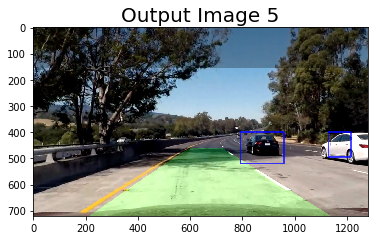

In [19]:
def pipeline(img):

    img_undist, img_lane_augmented, lane_info = process_frame(img)
    output = vehicle_detection(img_undist, img_lane_augmented, lane_info)

    return output

if __name__ == "__main__":
   
    filename = 'test_images/test5.jpg'
    image = mpimg.imread(filename)

    draw_img = pipeline(image)
    fig = plt.figure()
    plt.imshow(draw_img)
    plt.title('Output Image 5', fontsize=20)
    mpimg.imsave('output_images/test5_output.jpg',draw_img)
    plt.show()


## Test Videos

In [23]:
from moviepy.editor import VideoFileClip

if __name__ == "__main__":

    video_output = 'output_images/full_output_project_video.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    #clip1 = VideoFileClip("project_video.mp4").subclip(30,32)
    clip = clip1.fl_image(pipeline)
    clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video output_images/full_output_project_video.mp4
[MoviePy] Writing video output_images/full_output_project_video.mp4


100%|█████████▉| 1260/1261 [21:21<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/full_output_project_video.mp4 

